# Data exploration notebook

A simple notebook just to look at the data we got and start to experiment around.

In [103]:
import pandas as pd
import numpy as np
import yfinance as yf

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [10]:
assets = pd.read_csv("../data/assets_m6.csv")
universe = pd.read_csv("../data/M6_Universe.csv", index_col=0)

In [77]:
def get_company_name(ticker_symbol, universe=universe):
    return universe[universe.symbol==ticker_symbol].name.iloc[0]

In [14]:
universe.head()

,class,symbol,name,GICS_sector/ETF_type,GICS_industry/ETF_subtype
id,,,,,
1,Stock,ABBV,AbbVie,Health Care,Pharmaceuticals
2,Stock,ACN,Accenture,Information Technology,IT Consulting & Other Services
3,Stock,AEP,American Electric Power,Utilities,Electric Utilities
4,Stock,AIZ,Assurant,Financials,Multi-line Insurance
5,Stock,ALLE,Allegion,Industrials,Building Products


In [13]:
universe.groupby("class")["name"].count()

class
ETF      50
Stock    50
Name: name, dtype: int64

In [15]:
universe.groupby(["class", "GICS_sector/ETF_type"])["name"].count()

class  GICS_sector/ETF_type  
ETF    Commodities                3
       Equities                  37
       Fixed Income               9
       Volatility                 1
Stock  Communication Services     3
       Consumer Discretionary     6
       Consumer Staples           3
       Energy                     2
       Financials                 7
       Health Care                6
       Industrials                7
       Information Technology     7
       Materials                  3
       Real Estate                3
       Utilities                  3
Name: name, dtype: int64

In [16]:
universe.groupby(["class", "GICS_industry/ETF_subtype"])["name"].count()

class  GICS_industry/ETF_subtype            
ETF    Credit-Europe                             2
       Credit-US                                 2
       Diversified Commodity                     1
       Equity Style-Europe                       3
       Equity Style-North America                3
       Govt-Europe                               1
       Govt-Global                               1
       Govt-US                                   3
       Large Cap-Asia                            7
       Large Cap-Europe                          4
       Large Cap-Global                          1
       Large Cap-North America                   2
       Large Cap-South America                   1
       Precious Metals                           2
       Sector-Global                             4
       Sector-US                                10
       Small Cap-Europe                          1
       Small Cap-North America                   1
       US                            

In [33]:
all_stocks_hist = pd.DataFrame()
for iid in tqdm(universe.index):
    ticker = universe.loc[iid, "symbol"]
    stock = yf.Ticker(ticker)
    hist = stock.history(period="max")
    all_stocks_hist[ticker] = hist.stack()

  0%|          | 0/100 [00:00<?, ?it/s]

21


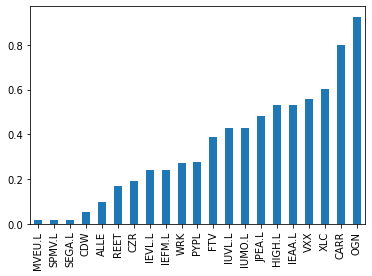

In [51]:
nan_fraction = all_stocks_hist.isna().mean().sort_values()
(nan_fraction[nan_fraction > 0]).plot.bar()
print(nan_fraction[nan_fraction > 0].shape[0])

In [58]:
closing_prices = all_stocks_hist.unstack(-1).swaplevel(axis=1)["Close"].bfill()  # backfilling price

<AxesSubplot:xlabel='Date'>

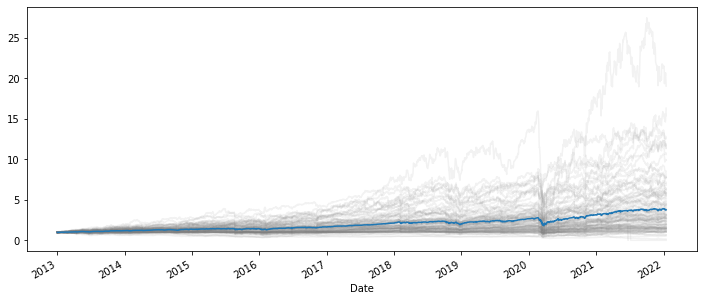

In [101]:
(closing_prices / closing_prices.iloc[0]).plot(legend=False, color="gray", alpha=0.1, figsize=(12, 5))
(closing_prices / closing_prices.iloc[0]).mean(axis=1).plot()

In [107]:
price_corr = closing_prices.corr()

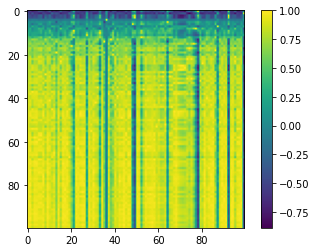

In [108]:
plt.imshow(price_corr.sort_values(price_corr.columns[0]))
plt.colorbar()

In [64]:
daily_returns = np.log(1 + closing_prices.pct_change().dropna())

In [71]:
monthly_returns = daily_returns.resample("MS").sum()

<AxesSubplot:>

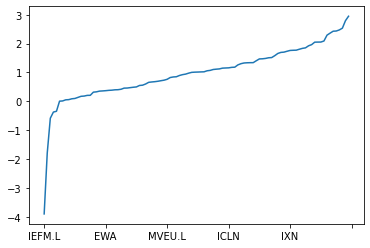

In [84]:
monthly_returns.sum().sort_values().plot()

In [138]:
monthly_quintiles = monthly_returns.apply(lambda x: (x.rank(ascending=False) // 20 +1).clip(upper=5)).astype(int)

In [139]:
monthly_quintiles.head()

,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,...,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2,3,2,1,4,2,3,3,5,1,...,3,1,1,2,2,4,3,2,3,3
2013-02-01,4,3,2,1,4,3,3,4,5,2,...,4,3,3,3,3,4,3,2,5,3
2013-03-01,1,3,2,2,4,4,2,4,3,2,...,2,1,2,2,3,4,1,1,3,3
2013-04-01,1,1,1,2,4,2,4,5,1,5,...,3,2,4,2,4,4,1,2,3,3
2013-05-01,5,4,5,2,4,3,1,2,4,2,...,1,3,2,2,2,4,5,5,3,3
